# Imports

In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data.dataloader as dataloader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

torch.manual_seed(42)

Device: cuda


# Transformations

In [2]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # Randomly crop the image to 32x32
    transforms.RandomHorizontalFlip(p=0.5), # Randomly flip the image horizontally each time you pull it with a 50% chance
    transforms.ToTensor(), # Convert image to tensor and scale to 0, 1
    transforms.Normalize([0.49139968, 0.48215827, 0.44653124],
                         [0.24703233, 0.24348505, 0.26158768]) # Normalize to mean and std of training set
])

# Typically with validation and testing sets, you don't apply any augmentation to keep it as close to real-world data as possible
test_transform = transforms.Compose([
    transforms.ToTensor(), # Convert image to tensor and scale to 0, 1
    transforms.Normalize([0.49139968, 0.48215827, 0.44653124],
                         [0.24703233, 0.24348505, 0.26158768]) # Normalize to mean and std of training set
])

# CIFAR10 Loading

60,000 sized dataset of images belonging to 10 classes. The 10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.  

In [3]:
dataset_train = datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)
dataset_test = datasets.CIFAR10(root='./data', train=False, transform=test_transform, download=True)

print(len(dataset_train))
print(len(dataset_test))

50000
10000


In [4]:
dataloader_train = dataloader.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
dataloader_test = dataloader.DataLoader(dataset_test, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# Convolutional NN

In [5]:
# Can do a custom CNN, or do a nn.Sequential(). For this, we'll do a custom CNN.

# model = nn.Sequential(
#     nn.Conv2d(3, 16, kernel_size=3, padding=1), # (batch_size, 16, 32, 32)
#     nn.ReLU(),
#     nn.MaxPool2d(2, 2), # (batch_size, 16, 16, 16)
#     nn.Conv2d(16, 32, kernel_size=3, padding=1), # (batch_size, 32, 16, 16)
#     nn.ReLU(),
#     nn.MaxPool2d(2, 2), # (batch_size, 32, 8, 8)
#     nn.Flatten(), # (batch_size, 32 * 8 * 8)
#     nn.Linear(32 * 8 * 8, 64),
#     nn.ReLU(),
#     nn.Linear(64, 10)
# )

class ToyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # (batch_size, 16, 32, 32)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # (batch_size, 32, 16, 16)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten() # (batch_size, 32 * 8 * 8)
        self.linear1 = nn.Linear(32 * 8 * 8, 64)
        self.linear2 = nn.Linear(64, 10)

        # Kaiming / He initialization is typically more stable for ReLU and LeakyReLU activations
        # Xavier initialization is typically better for the other popular activations like tanh and sigmoid
        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity="relu")
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity="relu")
        nn.init.kaiming_normal_(self.linear1.weight, nonlinearity="relu")
        nn.init.kaiming_normal_(self.linear2.weight, nonlinearity="relu")

        # Initialize biases to 0
        nn.init.zeros_(self.conv1.bias)
        nn.init.zeros_(self.conv2.bias)
        nn.init.zeros_(self.linear1.bias)
        nn.init.zeros_(self.linear2.bias)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x


model_sgd = ToyCNN()
model_adam = ToyCNN()

model_sgd.to(device)
model_adam.to(device)

ToyCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=2048, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=10, bias=True)
)

# Losses and Optimizers

In [6]:
criterion = nn.CrossEntropyLoss()

optimizer_sgd = torch.optim.SGD(model_sgd.parameters(), lr=0.001, momentum=0.9)
optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=0.001)

# Reduces learning rate when the loss plateaus for 10 epochs
scheduler_sgd = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_sgd, "min", patience=5, factor=0.1)
scheduler_adam = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_adam, "min", patience=5, factor=0.1)

# Initialization

In [7]:
epochs = 50

def train(model, optimizer, scheduler):
    metrics = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for epoch in range(epochs):

        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        model.train()
        for X, y in dataloader_train:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            optimizer.zero_grad()
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += (pred.argmax(dim=1) == y).sum().item()

        with torch.no_grad():
            model.eval()
            for X, y in dataloader_test:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                loss = criterion(pred, y)

                val_loss += loss.item()
                val_acc += (pred.argmax(dim=1) == y).sum().item()

        train_loss /= len(dataloader_train)
        train_acc /= len(dataset_train)
        val_loss /= len(dataloader_test)
        val_acc /= len(dataset_test)

        scheduler.step(val_loss) # Update validation loss if it's stagnant

        metrics["train_loss"].append(train_loss)
        metrics["train_acc"].append(train_acc)
        metrics["test_loss"].append(val_loss)
        metrics["test_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Test Loss: {val_loss:.4f}, Test Acc: {val_acc:.4f}")

    return model, metrics

# Adam Train

In [8]:
model_adam, metrics_adam = train(model_adam, optimizer_adam, scheduler_adam)

Epoch 1/50 | Train Loss: 1.7549, Train Acc: 0.3658 | Test Loss: 1.4227, Test Acc: 0.4867
Epoch 2/50 | Train Loss: 1.4249, Train Acc: 0.4870 | Test Loss: 1.3045, Test Acc: 0.5376
Epoch 3/50 | Train Loss: 1.3069, Train Acc: 0.5354 | Test Loss: 1.1743, Test Acc: 0.5813
Epoch 4/50 | Train Loss: 1.2258, Train Acc: 0.5636 | Test Loss: 1.1155, Test Acc: 0.6055
Epoch 5/50 | Train Loss: 1.1741, Train Acc: 0.5852 | Test Loss: 1.0544, Test Acc: 0.6297
Epoch 6/50 | Train Loss: 1.1305, Train Acc: 0.6019 | Test Loss: 1.0243, Test Acc: 0.6408
Epoch 7/50 | Train Loss: 1.0999, Train Acc: 0.6147 | Test Loss: 0.9869, Test Acc: 0.6559
Epoch 8/50 | Train Loss: 1.0755, Train Acc: 0.6211 | Test Loss: 0.9960, Test Acc: 0.6515
Epoch 9/50 | Train Loss: 1.0589, Train Acc: 0.6287 | Test Loss: 0.9565, Test Acc: 0.6673
Epoch 10/50 | Train Loss: 1.0299, Train Acc: 0.6404 | Test Loss: 0.9562, Test Acc: 0.6694
Epoch 11/50 | Train Loss: 1.0205, Train Acc: 0.6407 | Test Loss: 0.9651, Test Acc: 0.6618
Epoch 12/50 | Train

# SGD Train

In [9]:
model_sgd, metrics_sgd = train(model_sgd, optimizer_sgd, scheduler_sgd)

Epoch 1/50 | Train Loss: 1.9606, Train Acc: 0.2945 | Test Loss: 1.7486, Test Acc: 0.3779
Epoch 2/50 | Train Loss: 1.6880, Train Acc: 0.3914 | Test Loss: 1.5898, Test Acc: 0.4305
Epoch 3/50 | Train Loss: 1.5798, Train Acc: 0.4296 | Test Loss: 1.5119, Test Acc: 0.4610
Epoch 4/50 | Train Loss: 1.5038, Train Acc: 0.4567 | Test Loss: 1.4369, Test Acc: 0.4886
Epoch 5/50 | Train Loss: 1.4554, Train Acc: 0.4775 | Test Loss: 1.3893, Test Acc: 0.5065
Epoch 6/50 | Train Loss: 1.4199, Train Acc: 0.4895 | Test Loss: 1.3721, Test Acc: 0.5064
Epoch 7/50 | Train Loss: 1.3869, Train Acc: 0.5021 | Test Loss: 1.3298, Test Acc: 0.5233
Epoch 8/50 | Train Loss: 1.3613, Train Acc: 0.5109 | Test Loss: 1.2624, Test Acc: 0.5468
Epoch 9/50 | Train Loss: 1.3360, Train Acc: 0.5211 | Test Loss: 1.2631, Test Acc: 0.5477
Epoch 10/50 | Train Loss: 1.3158, Train Acc: 0.5298 | Test Loss: 1.2236, Test Acc: 0.5630
Epoch 11/50 | Train Loss: 1.2870, Train Acc: 0.5407 | Test Loss: 1.2048, Test Acc: 0.5681
Epoch 12/50 | Train

# Visualization

Block generated by AI

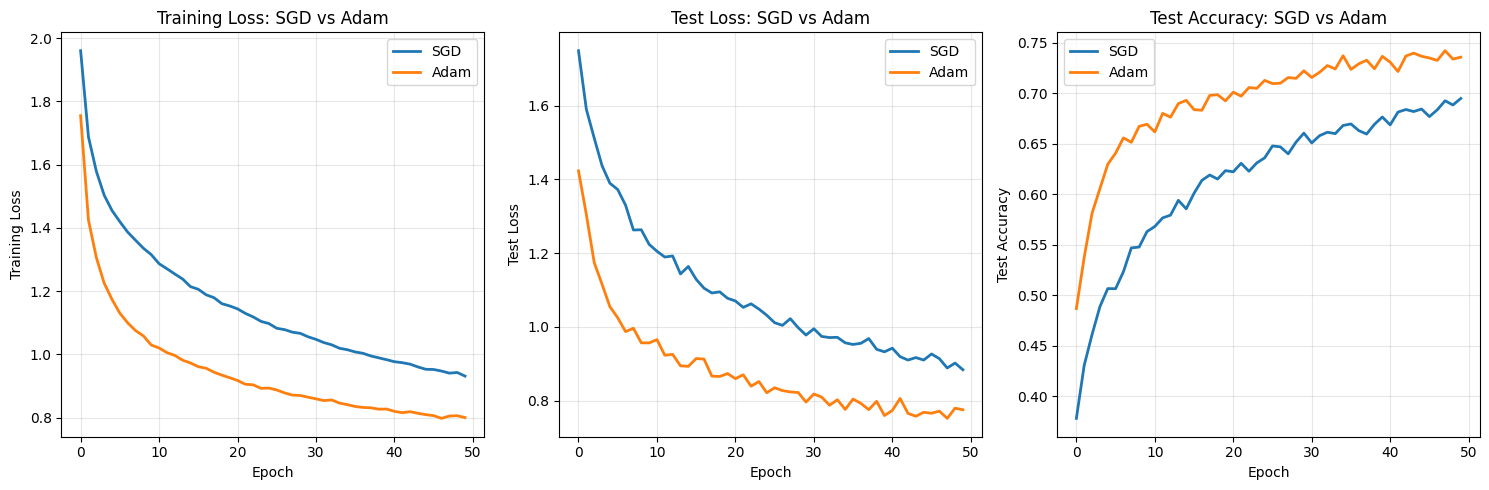


=== Final Performance Comparison ===
SGD - Final Train Loss: 0.9316, Final Test Acc: 0.6950
Adam - Final Train Loss: 0.8005, Final Test Acc: 0.7359


In [10]:
# Visualization - Compare SGD vs Adam

plt.figure(figsize=(15, 5))

# Plot 1: Training Loss Comparison
plt.subplot(1, 3, 1)
plt.plot(metrics_sgd["train_loss"], label="SGD", linewidth=2)
plt.plot(metrics_adam["train_loss"], label="Adam", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss: SGD vs Adam")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Test Loss Comparison
plt.subplot(1, 3, 2)
plt.plot(metrics_sgd["test_loss"], label="SGD", linewidth=2)
plt.plot(metrics_adam["test_loss"], label="Adam", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.title("Test Loss: SGD vs Adam")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Test Accuracy Comparison
plt.subplot(1, 3, 3)
plt.plot(metrics_sgd["test_acc"], label="SGD", linewidth=2)
plt.plot(metrics_adam["test_acc"], label="Adam", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy: SGD vs Adam")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final comparison
print("\n=== Final Performance Comparison ===")
print(f"SGD - Final Train Loss: {metrics_sgd['train_loss'][-1]:.4f}, Final Test Acc: {metrics_sgd['test_acc'][-1]:.4f}")
print(f"Adam - Final Train Loss: {metrics_adam['train_loss'][-1]:.4f}, Final Test Acc: {metrics_adam['test_acc'][-1]:.4f}")

# Optimizer Comparison: SGD vs Adam

## Experiment Setup
- **Dataset**: CIFAR-10 (50,000 training, 10,000 test images, 10 classes)
- **Model**: 2-layer CNN (Conv → ReLU → MaxPool → Conv → ReLU → MaxPool → Flatten → Linear → ReLU → Linear)
- **Learning Rate**: 0.001 (same for both optimizers for fair comparison)
- **Batch Size**: 128
- **Epochs**: 50
- **Scheduler**: ReduceLROnPlateau (patience=5, factor=0.1)
- **Data Augmentation**: Random crop (padding=4) + Random horizontal flip (training only)

## Results

### Final Performance
| Optimizer | Train Loss | Test Accuracy |
|-----------|------------|---------------|
| SGD       | 0.9316     | 69.50%        |
| Adam      | 0.8005     | 73.59%        |

### Observations
1. **Adam performed better**: Achieved ~4% higher test accuracy than SGD
2. **Training convergence**: Both optimizers showed steady improvement over 50 epochs
3. **Learning rate**: lr=0.001 worked well for both optimizers in this setup
4. **Adam faster convergence**: Adam reached higher accuracy earlier in training

## Key Takeaways
- **Adam's adaptive learning rates** helped achieve better generalization on this task
- **Same learning rate comparison**: Validates that Adam's adaptive mechanism provides advantages even with identical base learning rates
- Both optimizers are viable choices; Adam showed superior performance for this specific CNN architecture and dataset